In [67]:
import spacy
import torch
import itertools
import matplotlib.pyplot as plt
import numpy as np
from transformers import *
from custom.transformer_sentence import TransformerSentence
from custom.funcs import load_dataset

In [2]:
# LOAD PRETRAINED MODELS (this is the most costly)
# Bert base and large, uncased
BertBaseModel = BertModel.from_pretrained('bert-base-uncased')
BertBaseTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BertLargeModel = BertModel.from_pretrained('bert-large-uncased')
BertLargeTokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
# Scibert uncased
SciBertModel = BertModel.from_pretrained('scibert-scivocab-uncased')
SciBertTokenizer = BertTokenizer.from_pretrained('scibert-scivocab-uncased')
SciBertBaseVocabModel = BertModel.from_pretrained('scibert-basevocab-uncased')
SciBertBaseVocabTokenizer = BertTokenizer.from_pretrained('scibert-basevocab-uncased')

Load the test dataset from a .txt file into a list of sentences (list of strings).

In [57]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-5) # similarity func.

def remove_subsets(L):
    filtered = filter(lambda f: not any(set(f) < set(g) for g in L), L)
    return list(filtered)


def indices_to_compact_by_similarity_threshold(sequence_embeddings,
                                               sim_function=cos,
                                               threshold=0.1,
                                               exclude_special_tokens=True,
                                               combinatorics=None):
    # combinatorics= 'sequential', 'all'
    seq_length, embedding_size = sequence_embeddings.size() #make sure the input is proper size!!
    indices = list(range(seq_length))    
    
    # Combinations of indices that are group candidates
    if combinatorics == 'sequential':
        if exclude_special_tokens:
            idx_combinations = [indices[s:e] for s, e in itertools.combinations(range(1, len(indices)), 2)]
        else:
            idx_combinations = [indices[s:e] for s, e in itertools.combinations(range(len(indices)+1), 2)]
            
    elif combinatorics == 'all':
        idx_combinations = []
        for L in range(2, seq_length+1):
            combinations = list(itertools.combinations(indices, r=L))
            idx_combinations.extend(combinations)
    else:
        raise ValueError('You must specify the combinatorics as "sequencial" or "all"!!')
    
    
    all_indices_to_compact = []
    for indices in idx_combinations:
        group_candidate = sequence_embeddings[indices, :]
        group_size = len(indices)
        center = torch.mean(group_candidate, dim=0)
        center = center.repeat(group_size, 1)
        # calculate all embeddings similarities w.r.t. the center of the group
        similarities = sim_function(center, group_candidate)
        worst_sim, _ = torch.min(similarities, dim=0)
        if worst_sim > threshold: all_indices_to_compact.append(indices)
            
    indices_to_compact = remove_subsets(all_indices_to_compact)
    
    return indices_to_compact


def compact_embeddings(original_embeddings, indices_to_compact):
    new_embeddings_list = []
    for indices in indices_to_compact:
        group = original_embeddings[indices, :]
        center = torch.mean(group, dim=0)
        new_embeddings_list.append(center)
        
    new_embeddings = torch.stack(new_embeddings_list, dim=0)
    
    return new_embeddings


def recall_between_lists(ground_truth, prediction):
    recall, total = 0, 0
    for i, sentence in enumerate(ground_truth):
        for chunk in sentence:
            total += 1
            if chunk in prediction[i]: recall += 1
    return recall / total

In [58]:
sentences, sentences_obj = load_dataset(txt_path='../datasets/quora_questions.txt',
                                       return_embeddings=False,
                                       MODEL=SciBertModel,
                                       TOKENIZER=SciBertTokenizer)

sentences = [sentence.lower() for sentence in sentences]

100%|██████████| 301/301 [00:35<00:00,  8.37it/s]


In [30]:
# dummy short dataset fro debugging
#sentences = sentences[0:4]
#sentences_obj = sentences_obj[0:4]

In [59]:
#!python -m spacy download en
# Generate the spacy noun chunks as "ground truth"!
nlp = spacy.load("en") # en_core_web_sm

spacy_noun_chunks = [] # this is gonna be a list of lists
for sentence in sentences:
    doc = nlp(sentence)
    chunks = []
    for chunk in doc.noun_chunks:
        joint_token = str(chunk).replace(' ', '_')
        chunks.append(joint_token)
    spacy_noun_chunks.append(chunks)

In [84]:
def chunks_prediction_from_sentence_objects(sentences_obj, thr=0.9, model_layer=-1):
    transformer_chunks = [] #this is gonna be a list of lists
    for transformer_sentence in sentences_obj:
        sentence_tokens = transformer_sentence.summary['input_tokens']
        full_representation = transformer_sentence.summary['states'][model_layer, :, :]
        indices_to_compact = indices_to_compact_by_similarity_threshold(full_representation,
                                                                        sim_function=cos,
                                                                        threshold=thr,
                                                                        exclude_special_tokens=True,
                                                                        combinatorics='sequential')
        chunks = []
        for chunk_indices in indices_to_compact:
            if len(chunk_indices) > 1:
                tokens = [sentence_tokens[i] for i in chunk_indices]
                # remove leading ## and everything after _ in tokens to match the words
                tokens = [re.sub(r'_(.*)', '', token).replace('##', '') for token in tokens]
                joint_token = '_'.join(tokens)
                chunks.append(joint_token)

        transformer_chunks.append(chunks)
    return transformer_chunks

ValueError: x and y must have same first dimension, but have shapes (8,) and (16,)

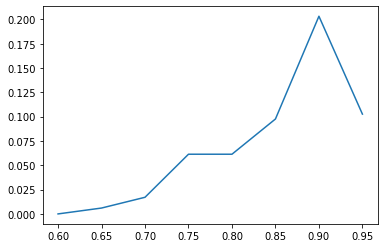

In [92]:
thrs = np.arange(0.60, 1., 0.05)
layer = list(range(-1, -10, -1))
for L in layer:
    recalls = []
    for thr in thrs:
        tf_chunks = chunks_prediction_from_sentence_objects(sentences_obj, thr=thr, model_layer=L)
        r = recall_between_lists(spacy_noun_chunks, tf_chunks)
        recalls.append(r)

    plt.plot(thrs, recalls)

In [88]:
thr=0.9
tf_chunks = chunks_prediction_from_sentence_objects(sentences_obj, thr=thr, model_layer=-5)
for i in range(5):
    print(sentences_obj[i].raw_string)
    print(f'Noun chunks, thr={thr}:', tf_chunks[i])

Are convolutional neural networks useful for tasks other than image classification?
Noun chunks, thr=0.9: ['convolutional_neural_networks', 'networks_useful', 'useful_for', 'for_tasks', 'other_than', 'image_classification']
Are non-causal temporal convolutions the equivalence of Bi-LSTM?
Noun chunks, thr=0.9: ['non_-', 'causal_temporal', 'temporal_convolution', 'convolution_s', 's_the', 'bi_-', 'ls_tm']
Are there any techniques, other than RNN/LSTM, to handle time series data?
Noun chunks, thr=0.9: ['there_any', 'other_than', 'rn_n', ',_to', 'to_handle', 'time_series', 'series_data']
Bayesian Inference: What is a Dirichlet process in layman's terms?
Noun chunks, thr=0.9: ['bayesian_inference', 'is_a', 'dirichlet_process', "'_s"]
Can an objective account of statistical inference be based on frequentist methods and Bayesian methods?
Noun chunks, thr=0.9: ['an_objective', 'objective_account', 'account_of', 'of_statistical', 'statistical_inference', 'be_based', 'based_on', 'ist_methods', '

In [91]:
list(range(-1, -10, -1))

[-1, -2, -3, -4, -5, -6, -7, -8, -9]